# Algorithmic Trading | Livetesting

## Strategy 1: Swing Trading Strategy

In [2]:

import requests
import pandas as pd
import ccxt
import time
import ta
from pandas import json_normalize
from datetime import datetime, timezone, timedelta
import numpy as np


ClientID = "myID"
ClientSecret = "mySecret"
response = requests.get("https://test.deribit.com/api/v2/public/auth?client_id="+ClientID+"&client_secret="+
                        ClientSecret+"&grant_type=client_credentials")
response_json = response.json()
response_json["result"]

#define how many hours to run the code
duration_hours = 6
# Calculate the end time
end_time = datetime.now() + timedelta(hours=duration_hours)
#define empty list
buydates = []
buyprices = []
selldates = []
sellprices = []
last_rows = []

# Run the loop until the current time reaches the end time
while datetime.now() < end_time:
    # function to obtain the current market price
    def get_market(instrument):
        # Define the URL of the endpoint
        url = "https://www.deribit.com/api/v2/public/get_book_summary_by_instrument"

        # Define the parameters
        params = {
            "instrument_name": instrument,  # Cryptocurrency to fetch data for
        }
        # Send the GET request; as public request, we don't have to authenticate
        response = requests.get(url, params=params)

        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()  # Parse the response to JSON
            print('Download market data was successful')  # Print the data
        else:
            print(f"Failed to retrieve data: {response.status_code}")
        market_data = pd.DataFrame(data["result"])
        market_price = int(market_data['mark_price'].values[0].round(-1))
        print(f"Current market price: {market_price}")
        return market_price

    #download last 51 rows in order to calculate stock_k and stock_d
    def get_minute_data(symbol, interval, lookback):
        exchange = ccxt.deribit({
            'apiKey': ClientID,
            'secret': ClientSecret,
        })
        # Retrieve historical klines data
        klines = exchange.fetch_ohlcv(symbol, interval, limit=lookback)
        # Convert klines data to a DataFrame
        df = pd.DataFrame(klines, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        df.set_index('time', inplace=True)
        df = df.astype(float)
        return df
    # Example usage
    df = get_minute_data('BTC-PERPETUAL', '1m', 50)

    # function to define additional variables in DataFrame
    def define_variable(df):
        df['stoch_k'] = ta.momentum.stoch(df.high, df.low, df.close, window=14, smooth_window=3)
        df['stoch_d'] = df['stoch_k'].rolling(3).mean()
        for i in (8, 14, 50):
            df['ema_' + str(i)] = ta.trend.ema_indicator(df.close, window=i)
        df['atr'] = ta.volatility.average_true_range(df.high, df.low, df.close)
        def checkcross(df):
            return (df['stoch_k'] > df['stoch_d'])& \
                (df['stoch_k'] > df['stoch_d']).diff()
        df['cross'] = checkcross(df)
        df.dropna(inplace=True)
        volume_confirmation = df.volume > df.volume.shift()
        df['tp'] = get_market("BTC-PERPETUAL") + (df.atr * 3)
        df['sl'] = get_market("BTC-PERPETUAL") - (df.atr * 4)
        df['buysignal'] = np.where((volume_confirmation) &
                                   (df.cross) &
                                   (df.close > df.ema_8) &
                                   (df.ema_8 > df.ema_14) &
                                   (df.ema_14 > df.ema_50), 1, 0)
        print(df.tail(1))

    # Define additional variables in DataFrame
    define_variable(df)
    in_position = False
    tp_values, sl_values = [], []

    def buy(params, df):
        # Define the URL of the endpoint
        url = "https://test.deribit.com/api/v2/private/buy"
        # Send the GET request
        response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
        if response.status_code == 200:
            data = response.json()  # Parse the response to JSON
            print(f"Trade was successful: {data['result']}")
            sl = df['sl'].iloc[-1]
            tp = df['tp'].iloc[-1]
            tp_values.append(tp)
            sl_values.append(sl)
        else:
            print(f"Failed to trade: {response.status_code}")
        response_json = response.json()

    # Define the parameters
    params = {
        "amount": get_market("BTC-PERPETUAL"),
        "instrument_name": "BTC-PERPETUAL",
        "type": "market"
    }

    if df['buysignal'].iloc[-1] == 1:
        buy(params, df)
        in_position = True
        buydates.append(df.index[-2])
        buyprices.append(get_market("BTC-PERPETUAL"))

    def sell(amount):
        url = "https://test.deribit.com/api/v2/private/sell"
        params = {
            "amount": amount,
            "instrument_name": "BTC-PERPETUAL",
            "type": "market",
        }
        response = requests.get(url, params=params, auth=(ClientID, ClientSecret))

        if response.status_code == 200:
            response = response.json()
            order_id = response["result"]["order"]["order_id"]
            print(f"The order was carried out satisfactorily. Order ID: {order_id}")
        else:
            print(f"Failed to retrieve data: {response.status_code}")

    if buyprices:
        for i in range(len(tp_values)):
            if get_market("BTC-PERPETUAL") > tp_values[i]:
                sell(amount=get_market("BTC-PERPETUAL"))
            elif get_market("BTC-PERPETUAL") < sl_values[i]:
                sell(amount=get_market("BTC-PERPETUAL"))

    # Print a message to indicate that the code is running
    print("Running...")
    last_rows.append(df.tail(1))
    df.to_csv('data_trading.csv', mode='a', index=True, header=False)
    time.sleep(60)

#Calculate the performance of trades
# Define the URL of the endpoint
url = "https://test.deribit.com/api/v2/private/get_transaction_log"

# start date can be set individually (date as 1 days before today)
start_date = int((datetime.now(timezone.utc) - timedelta(days=1)).timestamp() * 1e3)  # required type: integer
# enddate = now
end_date = int(datetime.utcnow().timestamp() * 1e3)

# define the parameters
params = {
    "currency": "BTC",
    "start_timestamp": start_date,
    "end_timestamp": end_date
}

# Send the GET request
response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
json_response = response.json()
data = json_response['result']
# convert results to a dataframe
df = json_normalize(data, 'logs')
# here, we are only interested in the settlements not the trades
df_settlement = df[df['type']=='settlement']
print(df_settlement)

# close all opened trades
# Define the URL of the endpoint
url = "https://test.deribit.com/api/v2/private/cancel_all"
# Send the GET request
response = requests.get(url, auth=(ClientID, ClientSecret))
response_json = response.json()
response_json['result']


KeyError: 'result'

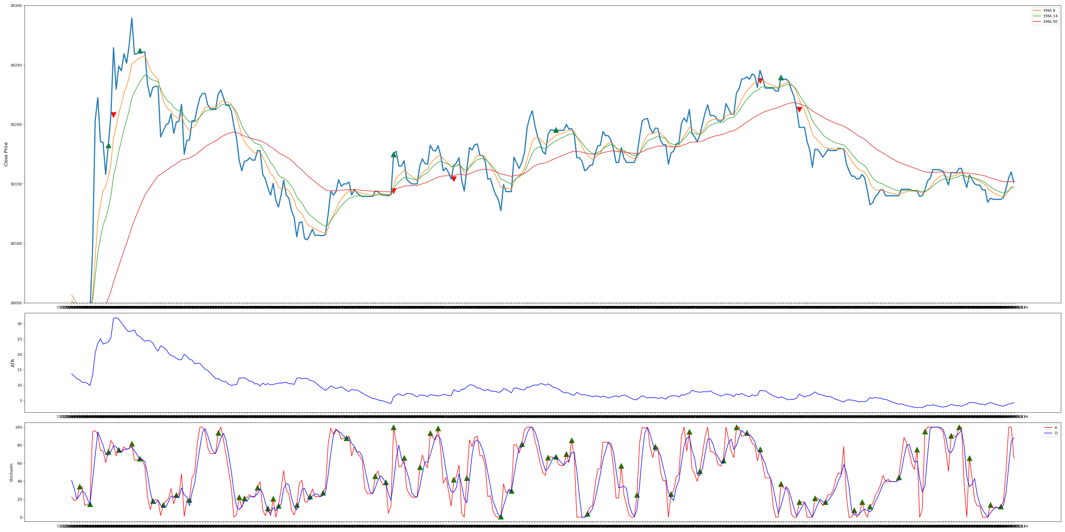

# Strategy 2: Simple Moving Average (MA) crossover strategy

In [ ]:
import requests
import pandas as pd
import ccxt
import time
from pandas import json_normalize
from datetime import datetime, timezone, timedelta
import numpy as np


ClientID = "myId"
ClientSecret = "mySecret"
response = requests.get("https://test.deribit.com/api/v2/public/auth?client_id="+ClientID+"&client_secret="+
                        ClientSecret+"&grant_type=client_credentials")
response_json = response.json()
response_json["result"]

#define how many hours to run the code
duration_hours = 6
# Calculate the end time
end_time = datetime.now() + timedelta(hours=duration_hours)
#define empty list
buydates = []
buyprices = []
selldates = []
sellprices = []
last_rows = []
# Run the loop until the current time reaches the end time
while datetime.now() < end_time:
    # function to obtain the current market price
    def get_market(instrument):
        # Define the URL of the endpoint
        url = "https://www.deribit.com/api/v2/public/get_book_summary_by_instrument"
        # Define the parameters
        params = {
            "instrument_name": instrument,  # Cryptocurrency to fetch data for
        }
        # Send the GET request; as public request, we don't have to authenticate
        response = requests.get(url, params=params)
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()  # Parse the response to JSON
            print('Download market data was successful')  # Print the data
        else:
            print(f"Failed to retrieve data: {response.status_code}")
        market_data = pd.DataFrame(data["result"])
        market_price = int(market_data['mark_price'].values[0].round(-1))
        print(f"Current market price: {market_price}")
        return market_price

    #download last 200 values in order to calculate long and short sma
    def get_minute_data(symbol, interval, lookback):
        exchange = ccxt.deribit({
            'apiKey': ClientID,
            'secret': ClientSecret,
        })
        # Retrieve historical klines data
        klines = exchange.fetch_ohlcv(symbol, interval, limit=lookback)
        # Convert klines data to a DataFrame
        df = pd.DataFrame(klines, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        df.set_index('time', inplace=True)
        df = df.astype(float)
        return df
    # Example usage
    df = get_minute_data('BTC-PERPETUAL', '1m', 200)

    # function to define additional variables in DataFrame
    def define_variable(df):
        df['log_return'] = np.log(df['close']).diff()
        # Calculate SMA crossover strategy
        short_window = 50
        long_window = 200
        df['short_ma'] = df['close'].rolling(window=short_window).mean()
        df['long_ma'] = df['close'].rolling(window=long_window).mean()
        df['sma_signal'] = np.where(df['short_ma'] > df['long_ma'], 1, 0)
        df['sma_position'] = (df['short_ma'] > df['long_ma']).diff()
        df['sma_trade'] = np.where(df['short_ma'] > df['long_ma'], 1, -1)
        df['sma_strategy_return'] = df['log_return'] * df['sma_trade']
        df.dropna(inplace=True)
        print(df.tail(1))

    # Define additional variables in DataFrame
    define_variable(df)
    in_position = False
    def buy(params, df):
        # Define the URL of the endpoint
        url = "https://test.deribit.com/api/v2/private/buy"
        # Send the GET request
        response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
        if response.status_code == 200:
            data = response.json()  # Parse the response to JSON
            print(f"Buying trade was successful: {data['result']}")
        else:
            print(f"Failed to trade: {response.status_code}")
        response_json = response.json()

    # Define the parameters
    params = {
        "amount": get_market("BTC-PERPETUAL"),
        "instrument_name": "BTC-PERPETUAL",
        "type": "market"
    }

    if df['sma_position'].iloc[-1] == 1 & df['sma_signal'].iloc[-1]==1:
        buy(params, df)
        in_position = True
        buydates.append(df.index[-1])
        buyprices.append(get_market("BTC-PERPETUAL"))

    def sell(amount):
        url = "https://test.deribit.com/api/v2/private/sell"
        params = {
            "amount": amount,
            "instrument_name": "BTC-PERPETUAL",
            "type": "market",
        }
        response = requests.get(url, params=params, auth=(ClientID, ClientSecret))

        if response.status_code == 200:
            response = response.json()
            order_id = response["result"]["order"]["order_id"]
            print(f"The order was carried out satisfactorily. Order ID: {order_id}")
        else:
            print(f"Failed to retrieve data: {response.status_code}")

    if df['sma_position'].iloc[-1] == 0 & df['sma_signal'].iloc[-1]==0:
        sell(amount=get_market("BTC-PERPETUAL"))


    # Print a message to indicate that the code is running
    print("Running...")
    last_rows.append(df.tail(1))
    df.to_csv('sma_data_trading.csv', mode='a', index=True, header=True)
    time.sleep(60)

#Calculate the performance trades.
# Define the URL of the endpoint
url = "https://test.deribit.com/api/v2/private/get_transaction_log"

# start date can be set individually (date as 1 days before today)
start_date = int((datetime.now(timezone.utc) - timedelta(days=1)).timestamp() * 1e3)  # required type: integer
# enddate = now
end_date = int(datetime.utcnow().timestamp() * 1e3)

# define the parameters
params = {
    "currency": "BTC",
    "start_timestamp": start_date,
    "end_timestamp": end_date
}

# Send the GET request
response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
json_response = response.json()
data = json_response['result']
# convert results to a dataframe
df = json_normalize(data, 'logs')
# here, we are only interested in the settlements not the trades
df_settlement = df[df['type']=='settlement']
print(df_settlement)

# close all opened trades

# Define the URL of the endpoint
url = "https://test.deribit.com/api/v2/private/cancel_all"
# Send the GET request
response = requests.get(url, auth=(ClientID, ClientSecret))
response_json = response.json()
response_json['result']